# 載入套件

In [1]:
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
import matplotlib.pyplot as plt
from joblib import dump, load

/home/samuel/.conda/envs/aicup/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,StackingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost

from sklearn.model_selection import GridSearchCV,  StratifiedKFold,KFold,RandomizedSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.utils.class_weight import compute_class_weight

# 資料路徑設定

In [56]:
medical_file_name = "./data/training datalist.csv"

# 載入訓練資料

In [3]:
source_df = pd.read_csv(medical_file_name)
print("source_df.shape :", source_df.shape)
print("source_df.columns :", source_df.columns)

source_df.shape : (1000, 28)
source_df.columns : Index(['ID', 'Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10'],
      dtype='object')


# 資料前處理

In [4]:
from sklearn.preprocessing import StandardScaler 
def medical_data_proccessing(df):
    medical_col = ['Sex', 'Age', 'Narrow pitch range',
                'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
                'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
                'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
                'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
                'Head and Neck Cancer', 'Head injury', 'CVA',
                'Voice handicap index - 10', 'Disease category']
    
    # 選定要訓練預測的類別
    df = df.loc[df['Disease category'].isin([1, 2, 3, 4, 5]), medical_col]

    # 將性別編碼0,1
    df['Sex'] = df['Sex'] - 1

    # 將空值填0
    df['PPD'] = df['PPD'].fillna(0)
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'].fillna(0)

    # 正規化過大的數值
    standardScaler = StandardScaler()
    df[['Age','Voice handicap index - 10']] = standardScaler.fit_transform(df[['Age','Voice handicap index - 10']])
    
    #把預測目標改為0~4
    df['Disease category'] = df['Disease category']-1
    return df

In [5]:
source_df = medical_data_proccessing(source_df)

print("Disease category in training_df :", source_df['Disease category'].unique())
print("training_df col :", source_df.columns)
print("training_df shape :", source_df.shape)

Disease category in training_df : [0 1 2 4 3]
training_df col : Index(['Sex', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'Smoking', 'PPD', 'Drinking', 'frequency', 'Diurnal pattern',
       'Onset of dysphonia ', 'Noise at work', 'Occupational vocal demand',
       'Diabetes', 'Hypertension', 'CAD', 'Head and Neck Cancer',
       'Head injury', 'CVA', 'Voice handicap index - 10', 'Disease category'],
      dtype='object')
training_df shape : (1000, 27)


## 訓練與驗證資料切分
* 確保training data與testing data個類別的比例相同
* 將training data分為兩部分first half與second half，前者用在first stage 訓練，後者用在second stage訓練

In [6]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for i in range(0,5):
    len_1=len(source_df[source_df['Disease category']==i])
    print(len_1)
    train_df = pd.concat([train_df,source_df[source_df['Disease category']==i].iloc[:int(len_1/6*5),:]])
    test_df = pd.concat([test_df,source_df[source_df['Disease category']==i].iloc[int(len_1/6*5):,:]])

536
220
168
44
32


In [7]:
train_df_first_half = pd.DataFrame()
for i in range(0,5):
    len_1=len(train_df[train_df['Disease category']==i])
    train_df_first_half = pd.concat([train_df_first_half,train_df[train_df['Disease category']==i].iloc[:int(len_1/2),:]])

In [8]:
train_df_first_half['Disease category'].value_counts()

Disease category
0    223
1     91
2     70
3     18
4     13
Name: count, dtype: int64

In [9]:
# 將資料做shuffle
train_df = train_df_first_half.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [10]:
train_df.shape, test_df.shape

((415, 27), (169, 27))

In [11]:
X_train = train_df.drop(["Disease category"],axis=1)
y_train = train_df.loc[:,'Disease category']
X_test = test_df.drop(["Disease category"],axis=1)
y_test = test_df.loc[:,'Disease category']
print("x_train.shape, y_train.shape :", X_train.shape, y_train.shape)
print("x_test.shape, y_test.shape :", X_test.shape, y_test.shape)

x_train.shape, y_train.shape : (415, 26) (415,)
x_test.shape, y_test.shape : (169, 26) (169,)


# 訓練病理特徵

### Baseline : 0.534

In [12]:
(y_test==0).sum()/len(y_test)

0.5325443786982249

## Voting

### 選五個最好的模型

In [13]:
#因為樣本有不平衡的情況，所有要設定各類別的取樣權重
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([0.37219731, 0.91208791, 1.18571429, 4.61111111, 6.38461538])

In [14]:
random_state = 42
clf = []
clf.append(SVC(random_state=random_state,class_weight=dict(enumerate(class_weights))))
clf.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state,class_weight=dict(enumerate(class_weights))),random_state=random_state,learning_rate=0.1))
clf.append(RandomForestClassifier(random_state=random_state,class_weight=dict(enumerate(class_weights))))
clf.append(GradientBoostingClassifier(random_state=random_state))
clf.append(KNeighborsClassifier())
clf.append(LogisticRegression(random_state = random_state,class_weight= dict(enumerate(class_weights))))
clf.append(xgboost.XGBClassifier(random_state=random_state))

In [15]:
cv_results_acc = []
kfold = StratifiedKFold(n_splits=5,shuffle=True)
for classifier in clf :
    cv_results_acc.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv =kfold , n_jobs=-1))

In [16]:
def mean_recall(clf,X,y):
    y_pred = clf.predict(X)
    results_recall = recall_score(y, y_pred, average=None).mean()
    return results_recall
cv_results_recall = []
for classifier in clf :
    cv_results_recall.append(cross_val_score(classifier, X_train, y = y_train, scoring = mean_recall, cv =kfold , n_jobs=-1))

In [17]:
cv_means_recall = []
cv_std_recall   = []
for cv_result in cv_results_recall:
    cv_means_recall.append(cv_result.mean())

cv_res_recall = pd.DataFrame({"CrossValMeans":cv_means_recall,"Algorithm":["SVC","AdaBoost",
"RandomForest","GradientBoosting","KNeighboors","Xgboost","LogisticRegression"]})

cv_means_acc = []
cv_std_acc   = []
for cv_result in cv_results_acc:
    cv_means_acc.append(cv_result.mean())
    # cv_std_acc.append(cv_result.std())

cv_res_acc = pd.DataFrame({"CrossValMeans":cv_means_acc,"Algorithm":["SVC","AdaBoost",
"RandomForest","GradientBoosting","KNeighboors","Xgboost","LogisticRegression"]})


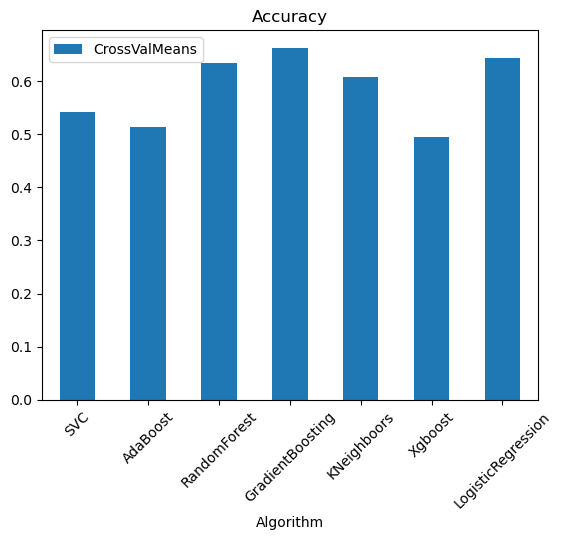

In [18]:
g = cv_res_acc.plot(kind='bar',xlabel='Algorithm')
g.set_xticklabels(cv_res_acc['Algorithm'].to_numpy())
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_title("Accuracy")
plt.show()

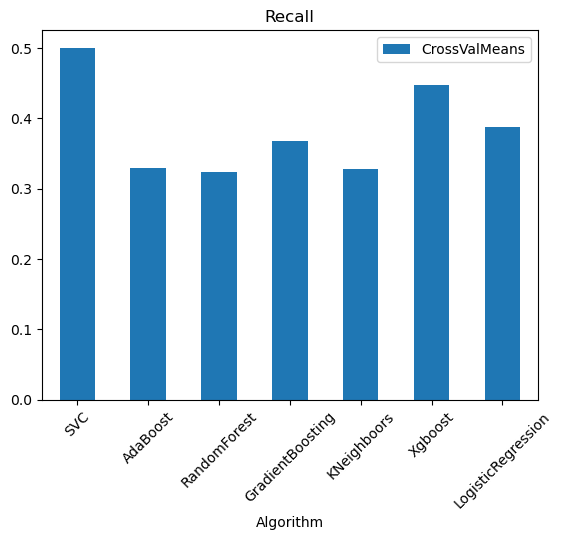

In [19]:
g = cv_res_recall.plot(kind='bar',xlabel='Algorithm')
g.set_xticklabels(cv_res_recall['Algorithm'].to_numpy())
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_title("Recall")
plt.show()

## 四個模型 : SVC、RF、GB、XGB、Logistic regression

### SVC

In [20]:
svm = SVC(probability=True,random_state=random_state,class_weight=dict(enumerate(class_weights)))
svc_param_grid = {'kernel': ['rbf'], 
      'gamma': [ 0.001, 0.01, 0.1, 1],
      'C': [1, 10, 100,200]}
gsSVMC = GridSearchCV(svm,param_grid = svc_param_grid, cv=kfold, scoring=mean_recall, n_jobs= -1, verbose = 1)
gsSVMC.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(class_weight={0: 0.3721973094170404,
                                         1: 0.9120879120879121,
                                         2: 1.1857142857142857,
                                         3: 4.611111111111111,
                                         4: 6.384615384615385},
                           probability=True, random_state=42),
             n_jobs=-1,
             param_grid={'C': [1, 10, 100, 200], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             scoring=<function mean_recall at 0x7fe47714d3a0>, verbose=1)

In [21]:
gsSVMC.best_score_,gsSVMC.best_params_

(0.5066282372598162, {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'})

In [22]:
mean_recall(gsSVMC,X_test,y_test)

0.5548906048906049

In [23]:
best_svm = gsSVMC.best_estimator_

### XGBoost

In [24]:
from sklearn.utils import class_weight
sample_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [25]:
xgb = xgboost.XGBClassifier(random_state=random_state)
param_test= {
 'n_estimators':[i*100 for i in range(1,10)],
    'max_depth':[1,2,3,4],
 'min_child_weight':range(3,7),
    'gamma':[i/10.0 for i in range(0,5)],
    "subsample": [i/10 for i in range(4,8)],
    "colsample_bytree":[i/10 for i in range(1,3)],
     'learning_rate':[i/10 for i in range(1,8)]
}

gs_xgb =RandomizedSearchCV(estimator=xgb,param_distributions=param_test,n_iter=50, cv =kfold,scoring=mean_recall,n_jobs=-1,random_state=random_state)
gs_xgb.fit(X_train, y_train,sample_weight = sample_weights)
# gs_xgb.best_params_, gs_xgb.best_score_

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           import...
                                           predictor=None, random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.2],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7],
                                        'max_depth': [1, 2, 3, 4],
                                        'min_child_weight': range(3, 7),
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900],
                                        'subsample': [0.4, 0.5, 0.6, 0.7]},
                   random_state=42,
                   scoring=<function mean_recall at 0x7fe47714d3a0>)

In [26]:
gs_xgb.best_params_, gs_xgb.best_score_

({'subsample': 0.5,
  'n_estimators': 300,
  'min_child_weight': 4,
  'max_depth': 2,
  'learning_rate': 0.1,
  'gamma': 0.0,
  'colsample_bytree': 0.1},
 0.5063975089238247)

In [27]:
mean_recall(gs_xgb,X_test,y_test)

0.5181703131703131

In [28]:
best_xgb = gs_xgb.best_estimator_

### GB

In [29]:
gbc = GradientBoostingClassifier(random_state=random_state)
gb_param_grid = {
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [6,7,8,9,10],
              'min_samples_leaf': [50,100,150],
              }
gs_gbc=RandomizedSearchCV(estimator=gbc,param_distributions=gb_param_grid,n_iter=30,random_state=random_state,scoring = mean_recall, 
                                     cv =kfold,n_jobs=-1)
gs_gbc.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.05, 0.01],
                                        'max_depth': [6, 7, 8, 9, 10],
                                        'min_samples_leaf': [50, 100, 150],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42,
                   scoring=<function mean_recall at 0x7fe47714d3a0>)

In [30]:
mean_recall(gs_gbc,X_test,y_test)

0.48227155727155735

In [31]:
gs_gbc.best_params_, gs_gbc.best_score_

({'n_estimators': 100,
  'min_samples_leaf': 50,
  'max_depth': 9,
  'learning_rate': 0.1},
 0.38941323004480904)

In [32]:
best_gbc = gs_gbc.best_estimator_

### Logistic

In [33]:
logreg = LogisticRegression(class_weight=dict(enumerate(class_weights)),random_state=random_state, max_iter=1000)
logreg_param_grid={
    'C':[100, 10, 1.0, 0.1, 0.01] ,
    "penalty":["l2"]
}
gs_logreg=GridSearchCV(logreg,param_grid = logreg_param_grid, cv=kfold, scoring=mean_recall, n_jobs= -1, verbose = 1)
gs_logreg.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LogisticRegression(class_weight={0: 0.3721973094170404,
                                                        1: 0.9120879120879121,
                                                        2: 1.1857142857142857,
                                                        3: 4.611111111111111,
                                                        4: 6.384615384615385},
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2']},
             scoring=<function mean_recall at 0x7fe47714d3a0>, verbose=1)

In [34]:
gs_logreg.best_params_, gs_logreg.best_score_

({'C': 0.1, 'penalty': 'l2'}, 0.5225984658616237)

In [35]:
mean_recall(gs_logreg,X_test,y_test)

0.558929643929644

In [36]:
best_log=gs_logreg.best_estimator_

## RandomForest

In [37]:
rf = RandomForestClassifier(random_state=random_state,class_weight=dict(enumerate(class_weights)))
param_test={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100,200, 300, 400, 500, 1000]}
gs_rf = RandomizedSearchCV(rf,param_test,cv=kfold,n_jobs=-1,scoring = mean_recall,random_state=random_state)
gs_rf.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=RandomForestClassifier(class_weight={0: 0.3721973094170404,
                                                                  1: 0.9120879120879121,
                                                                  2: 1.1857142857142857,
                                                                  3: 4.611111111111111,
                                                                  4: 6.384615384615385},
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 1000]},
                   random_state=42,
                   scoring=<function mean_recall at 0x7fe47714d3a0>)

In [38]:
gs_rf.best_params_,gs_rf.best_score_

({'n_estimators': 200,
  'min_samples_split': 5,
  'min_samples_leaf': 4,
  'max_features': 'sqrt',
  'max_depth': 100,
  'bootstrap': False},
 0.49372203235361134)

In [39]:
best_rf = gs_rf.best_estimator_

In [40]:
mean_recall(best_rf,X_test,y_test)

0.53499570999571

## Build voting classifier

In [41]:
votingc = VotingClassifier(estimators=[('xgboost',best_xgb),('rf',best_rf),('gbc',best_gbc),
('logreg',best_log),('svm',best_svm)], voting='hard', n_jobs=4)
cross_val_score(votingc,X_train,y_train,scoring=mean_recall).mean()

/home/samuel/.conda/envs/aicup/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/samuel/.conda/envs/aicup/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

0.470125920862763

In [42]:
votingc.fit(X_train, y_train)

### testing recall

Test UAR(Unweighted Average Recall) : 0.5181703131703131


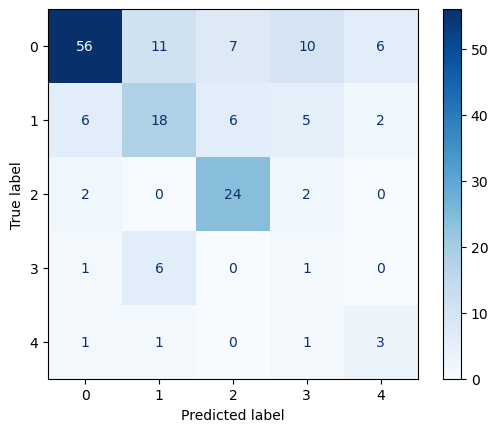

In [72]:
y_pred = best_xgb.predict(X_test)
results_recall = recall_score(y_test, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')

In [73]:
(y_pred==y_test).sum()/len(y_test)

0.6035502958579881

Test UAR(Unweighted Average Recall) : 0.5548906048906049


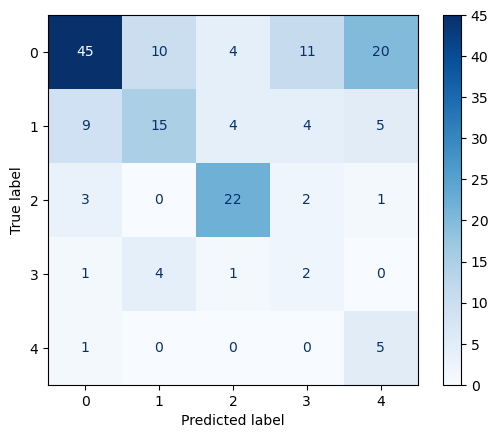

In [75]:
y_pred = best_svm.predict(X_test)
results_recall = recall_score(y_test, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')

In [76]:
(y_pred==y_test).sum()/len(y_test)

0.5266272189349113

Test UAR(Unweighted Average Recall) : 0.5487087087087087


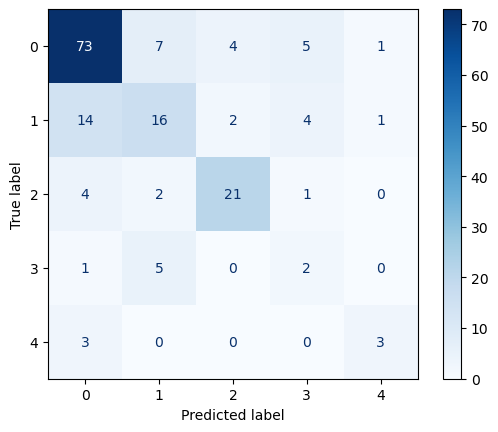

In [78]:
y_pred = votingc.predict(X_test)
results_recall = recall_score(y_test, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')

In [79]:
(y_pred==y_test).sum()/len(y_test)

0.6804733727810651

## Stacking model

In [44]:
estimators = [('rf',best_rf),('gbc',best_gbc),
('logreg',best_log),('svm',best_svm)]
s1 = StackingClassifier(estimators=estimators,final_estimator=best_xgb)
cross_val_score(s1,X_train,y_train,scoring=mean_recall).mean()

0.35202931571352625

In [45]:
estimators = [('rf',best_rf),('gbc',best_gbc),
('logreg',best_log),('xgb',best_xgb)]
s2 = StackingClassifier(estimators=estimators,final_estimator=best_svm)
cross_val_score(s2,X_train,y_train,scoring=mean_recall).mean()

0.44921819700767074

In [46]:
estimators = [('xgb',best_xgb),('gbc',best_gbc),
('logreg',best_log),('svm',best_svm)]
s3 = StackingClassifier(estimators=estimators,final_estimator=best_rf)
cross_val_score(s3,X_train,y_train,scoring=mean_recall).mean()

0.4360595427963849

In [47]:
estimators = [('rf',best_rf),('gbc',best_gbc),
('xgb',best_xgb),('svm',best_svm)]
s4 = StackingClassifier(estimators=estimators,final_estimator=best_log)
cross_val_score(s4,X_train,y_train,scoring=mean_recall).mean()

0.5076222374117111

In [48]:
estimators = [('rf',best_rf),('xgb',best_xgb),
('logreg',best_log),('svm',best_svm)]
s5 = StackingClassifier(estimators=estimators,final_estimator=best_gbc)
cross_val_score(s5,X_train,y_train,scoring=mean_recall).mean()

0.373413230044809

### 以logistic regression做meta model結果最好

In [54]:
s4.fit(X_train,y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       class_weight={0: 0.3721973094170404,
                                                                     1: 0.9120879120879121,
                                                                     2: 1.1857142857142857,
                                                                     3: 4.611111111111111,
                                                                     4: 6.384615384615385},
                                                       max_depth=100,
                                                       min_samples_leaf=4,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('gbc',
                                GradientBoostingClassifier(max_depth=9,
                                                           min_samples_leaf=50,
                                                           ra...
                                    class_weight={0: 0.3721973094170404,
                                                  1: 0.9120879120879121,
                                                  2: 1.1857142857142857,
                                                  3: 4.611111111111111,
                                                  4: 6.384615384615385},
                                    gamma=0.01, probability=True,
                                    random_state=42))],
                   final_estimator=LogisticRegression(C=0.1,
                                                      class_weight={0: 0.3721973094170404,
                                                                    1: 0.9120879120879121,
                                                                    2: 1.1857142857142857,
                                                                    3: 4.611111111111111,
                                                                    4: 6.384615384615385},
                                                      max_iter=1000,
                                                      random_state=42))

### testing recall

Test UAR(Unweighted Average Recall) : 0.4913277563277563


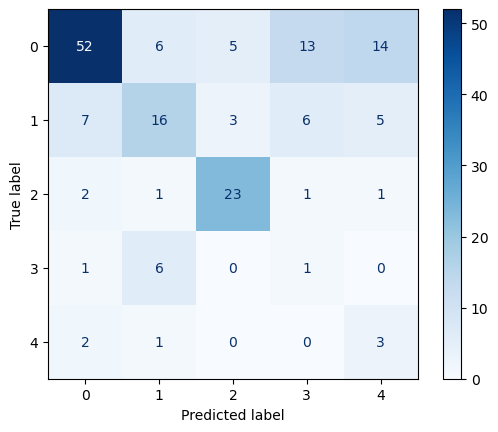

In [59]:
y_pred = s4.predict(X_test)
results_recall = recall_score(y_test, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')

## 以 votint model作為最終模型

In [57]:
medical_model = votingc
dump(votingc, 'AI_CUP_medical_model.joblib') 

['AI_CUP_medical_model.joblib']